# Practical Session 3 - Optimization

In this session we will talk about optimization in general and its application to machine learning.

First we will look into a general setting. Let us simply minimize the function :
 $ f(x) = x^2 $ when starting from $x_0=2$
 
 A one-liner for that is to use scipy.optimize

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import torch

In [3]:
def f(x):
    return x ** 2


x_0 = 2

result = scipy.optimize.minimize(f, x_0)
print(result.x)

[-1.88846401e-08]


### Implementing a random search

A first possible algorithm is to sample a change for x and keep the best value.
We iterate the following steps : 
- take a neighbor for x, sampling a random number 0.01.
- evaluate these two possibilities
- move to the best one

Implement that with a for loop with 1000 iterations.

-7.072363364489509e-05


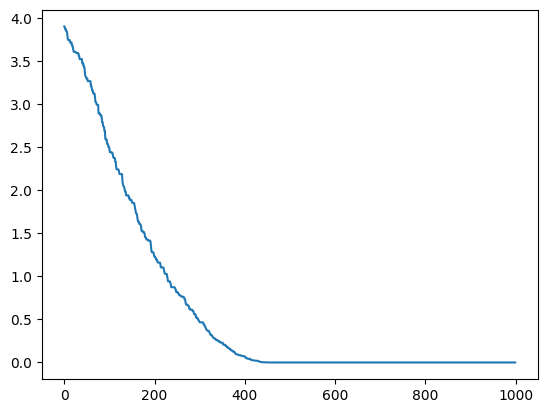

In [4]:
n_iter = 1000
x = x_0
all_results = list()


def sample_around(x):
    return x + np.random.normal(scale=0.01)


for _ in range(n_iter):
    sample = sample_around(x)
    f_x, f_sample = f(x), f(sample)
    # The best value is the sampled one
    if f_sample < f_x:
        x = sample
        all_results.append(f_sample)
    # The best one is the former one
    else:
        x = x
        all_results.append(f_x)

print(x)
plt.plot(all_results)

### Implementing an exaustive search

A first possible algorithm is to try all changes for x and keep the best value.
We iterate the following steps : 
- try a smaller and a larger x value of 0.01.
- evaluate these two possibilities
- move to the best one

Implement that with a for loop with 1000 iterations.

2


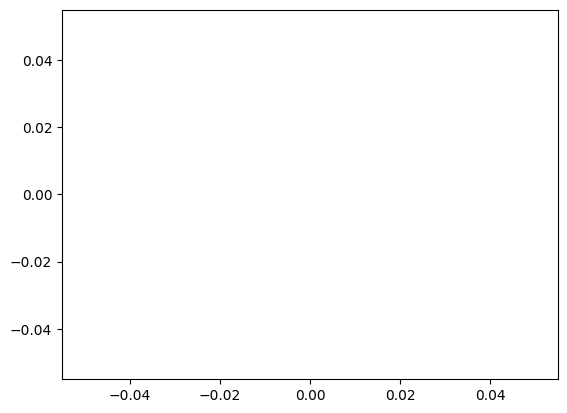

In [5]:
n_iter = 1000
x = x_0
all_results = list()

print(x)
plt.plot(all_results)

### Implementing a gradient descent 'by hand'
Now let us implement the gradient descent, by remembering that $\frac{df}{dx} = 2x$

We iterate the following steps : 
- compute the gradient value at x
- Update x : $x \leftarrow x - 0.01 \frac{df}{dx}$

Implement that with a for loop with 1000 iterations.

2


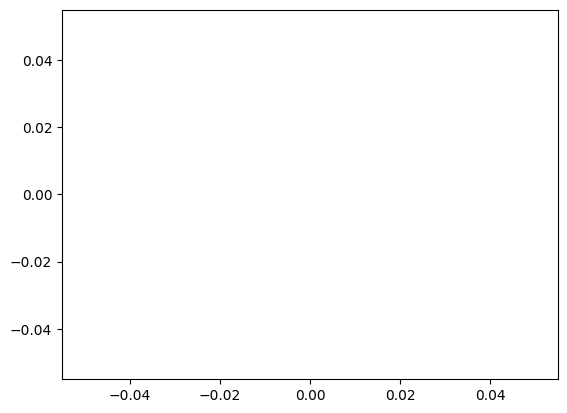

In [6]:
def df(x):
    return 2 * x


print(x)
plt.plot(all_results)

### Implementing a gradient descent with automatic differentiation (by hand)

We want to use the same algorithm but without knowing the formula of differentiation. 
We instead want to rely on Pytorch

Implement the same method as before, with PyTorch.

3.3659321996282188e-09


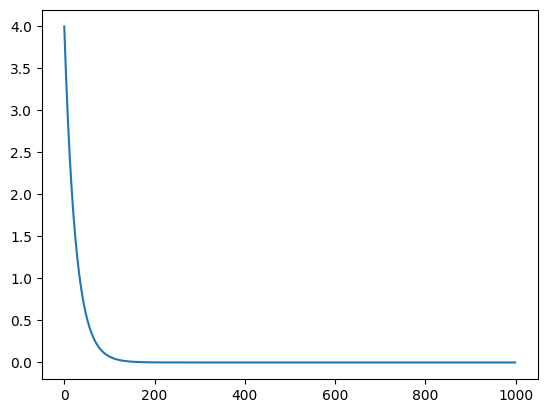

In [7]:
all_results = list()
n_iter = 1000
x = torch.tensor(2.0, requires_grad=True)
x.retain_grad()

for i in range(n_iter):
    f_x = x ** 2
    f_x.backward()
    x.data = x - 0.01 * x.grad.item()
    x.grad = None
    all_results.append(f_x.data)

print(x.item())
plt.plot(all_results)

### Implementing a gradient descent with automatic differentiation (the proper way)

3.365942857769255e-09


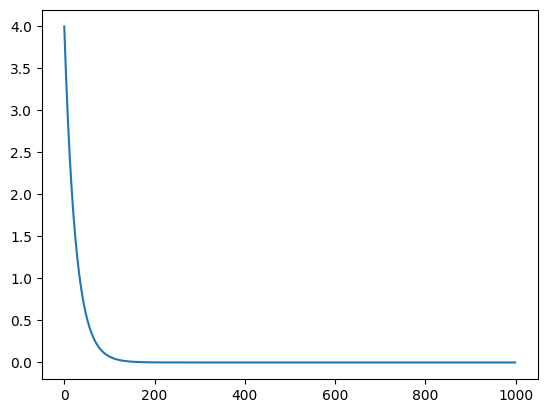

In [8]:
all_results = list()
n_iter = 1000
x = torch.tensor(2.0, requires_grad=True)
opt = torch.optim.SGD([x], lr=0.01, momentum=0)

for i in range(n_iter):
    f_x = f(x)
    f_x.backward()
    opt.step()
    opt.zero_grad()
    all_results.append(f_x.data)

print(x.item())
plt.plot(all_results)

## Bigger input space

Let us now look at a more complicated input space, the function takes as input five numbers and returns :
$f_2(x_1, x_2, x_3, x_4, x_5) = (x_1 + x_2 + x_3 + x_4 + x_5)^2$

Now it is more costly to find the right direction randomly. Try the random algorithm on this new function.

In [9]:
def f_2(x):
    return (x[0] + x[1] + x[2] + x[3] + x[4]) ** 2


new_x_0 = (1, 2, 3, 4, 5)
f_2(new_x_0)

225

(1, 2, 3, 4, 5)


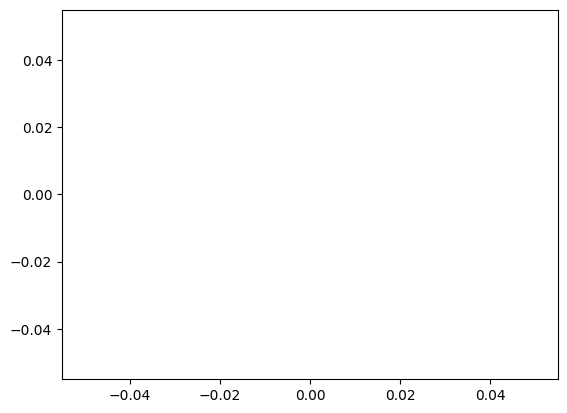

In [10]:
n_iter = 1000
x = new_x_0
all_results = list()


def sample_around(x):
    return x + np.random.normal(size=5, scale=0.01)


print(x)
plt.plot(all_results)

Now let us try the gradient approach.

tensor([1., 2., 3., 4., 5.], dtype=torch.float64)


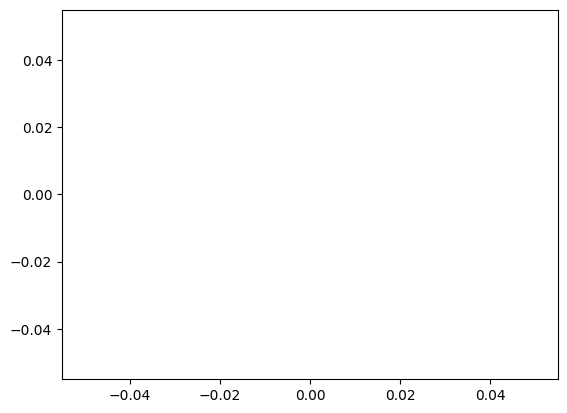

In [11]:
all_results = list()
n_iter = 1000
x = torch.tensor(new_x_0, requires_grad=True, dtype=float)
opt = torch.optim.SGD([x], lr=0.01, momentum=0)

print(x.data)
plt.plot(all_results)

## Actual machine learning examples

Now instead of minimizing random functions, let us minimize the error of a linear model !

We will simply use the example from the first class. Let us generate the data once again and plot it.

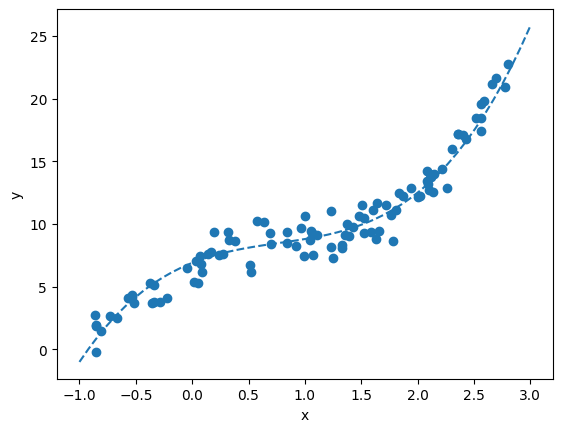

In [12]:
import numpy as np

np.random.seed(20)


def base_function(x):
    y = 1.3 * x ** 3 - 3 * x ** 2 + 3.6 * x + 6.9
    return y


low, high = -1, 3
n_points = 100

# Get the values
xs = np.random.uniform(low, high, n_points)
ys_noise = np.random.normal(size=len(xs))
sample_ys = base_function(xs)
noisy_sample_ys = sample_ys + ys_noise

# Plot the hidden function
lsp = np.linspace(low, high)[:, None]
true_ys = base_function(lsp)
plt.plot(lsp, true_ys, linestyle='dashed')

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Gradient descent using torch.
First create a torch version of these objects 

In [13]:
torch_noisy_sample_ys = torch.from_numpy(noisy_sample_ys)
torch_xs = torch.from_numpy(xs)
torch_lsp = torch.from_numpy(lsp)

Let us try to fit a linear model by hand, instead of simply relying on scikit-learn !

The model of a linear regression is : $f_\theta (x) = (\theta_0 x + \theta_1)$

Careful ! We do not want to minimize the function of x itself. 

We want to minimise the errors we make, also called the loss function. We will do this by adjusting the parameters $\theta$ of the function, starting from an arbitrary value of (1,1). This loss function is the sum of the square errors at each point : 

$$ \min_{\theta}\mathcal{L} (\theta) = 1/N\sum_i (y_i - f_{\theta} (x_i))^ 2 \\
= 1/N\sum_i (y_i - (\theta_0 x_i + \theta_1))^ 2 $$

In [14]:
def f_theta(x, theta):
    return theta[0] * x + theta[1]


def loss_function(theta):
    return torch.mean((torch_noisy_sample_ys - f_theta(torch_xs, theta)) ** 2)

# Implement optimization here
# ...

theta_0 = torch.tensor((1., 1.), requires_grad=True)
loss_function(theta_0)

tensor(76.6989, dtype=torch.float64, grad_fn=<MeanBackward0>)

tensor([1., 1.])


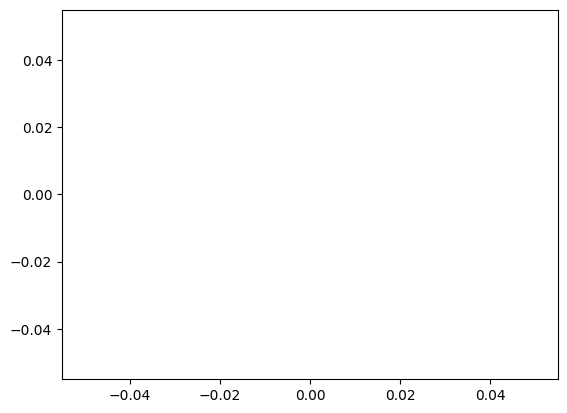

In [15]:
all_results = list()
n_iter = 1000
opt = torch.optim.SGD([theta_0], lr=0.01, momentum=0.0)

print(theta_0.data)
plt.plot(all_results)

We have values for the parameters now. 
Let us look at what they look like.

Use the theta_function on the linspace to plot your model.

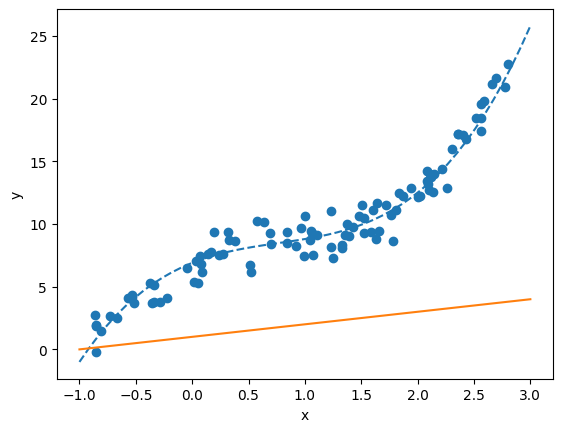

In [16]:
predicted_ys = f_theta(torch_lsp, theta_0).detach().numpy()

plt.plot(lsp, true_ys, linestyle='dashed')
plt.plot(lsp, predicted_ys)

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()